# Avaliação e validação de experimentos


In [ ]:
import numpy as np # Numpy: biblioteca para manipular vetores e matrizes
import pandas as pd # Pandas: biblioteca para manipular tabelas

Durante o curso, trabalharemos ba base de dados [Automobile](https://archive.ics.uci.edu/ml/datasets/Automobile) da UCI.  Esta base contém características de diversos automóveis e o risco (em termos de seguro) de cada um deles.  Consideraremos que as bases estão armazenadas em um arquivo [CSV](https://en.wikipedia.org/wiki/Comma-separated_values).

> Não esqueça de carregar o arquivo `imports85.csv` antes de rodar o código abaixo.

In [ ]:
!ls

imports85.csv  sample_data


In [ ]:
data = pd.read_csv('imports85.csv')
print(data.shape)

(205, 26)


In [ ]:
print(data.head())

   symboling  normalizedlosses         make fueltype aspiration numofdoors  \
0          3               NaN  alfa-romero      gas        std        two   
1          3               NaN  alfa-romero      gas        std        two   
2          1               NaN  alfa-romero      gas        std        two   
3          2             164.0         audi      gas        std       four   
4          2             164.0         audi      gas        std       four   

     bodystyle drivewheels enginelocation  wheelbase  ...  enginesize  \
0  convertible         rwd          front       88.6  ...         130   
1  convertible         rwd          front       88.6  ...         130   
2    hatchback         rwd          front       94.5  ...         152   
3        sedan         fwd          front       99.8  ...         109   
4        sedan         4wd          front       99.4  ...         136   

   fuelsystem  bore  stroke compressionratio horsepower  peakrpm citympg  \
0        mpfi  3

In [ ]:
X = data.drop(columns=['symboling', 'normalizedlosses', 'numofcylinders', 'numofdoors'])
# To simplify the code, we will only use numeric features
X = X.select_dtypes(exclude=['object'])
yreg = data.symboling
ycla = yreg > 0

print(X.shape)

(205, 14)


In [ ]:
# Semente aleatória para reproducibilidade dos experimentos (reproducão dos experimentos)
seed = 17

## Classificação

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
#from sklearn.neural_network import MLPClassifier

from sklearn.pipeline import Pipeline

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.feature_selection import VarianceThreshold, SelectKBest
from sklearn.decomposition import PCA

from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import make_scorer

In [ ]:
scorer = make_scorer(accuracy_score) # Teste outras

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
gscv = StratifiedKFold(n_splits=3, shuffle=True, random_state=seed)

algorithms = {
    'kNN':  GridSearchCV(
        Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', MinMaxScaler(feature_range=(0, 1))),
            ('selector', VarianceThreshold()),
            ('knn', KNeighborsClassifier())]),
        param_grid={
            'selector__threshold': [0, 0.01, 0.02, 0.03],
            'knn__n_neighbors': [1, 3, 5],
            'knn__p': [1, 2],
        },
        scoring=scorer,
        cv=gscv),
    'tree':  GridSearchCV(
        Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('tree', DecisionTreeClassifier(random_state=seed))]),
        param_grid={
            'tree__max_depth': [5, 10, 20],
            'tree__criterion': ['entropy', 'gini'],
        },
        scoring=scorer,
        cv=gscv),
    'bigtree':  GridSearchCV(
        Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('tree', DecisionTreeClassifier(max_depth=None, min_samples_split=2, random_state=seed))]),
        param_grid={
            'tree__criterion': ['entropy', 'gini'],
        },
        scoring=scorer,
        cv=gscv),
    'nb': GridSearchCV(
        Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('selector', SelectKBest()),
            ('nb', GaussianNB())]),
        param_grid={
            'selector__k': [3, 5, 10],
        },
        scoring=scorer,
        cv=gscv),
    'svmlinear': GridSearchCV(
        Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler()),
            ('pca', PCA()),
            ('svm', SVC(kernel='linear', random_state=seed))]),
        param_grid={
            'pca__n_components': [2, 5, 10],
            'svm__C': [1.0, 2.0],
        },
        scoring=scorer,
        cv=gscv),
    'svmrbf': GridSearchCV(
        Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler()),
            ('pca', PCA(random_state=seed)),
            ('svm', SVC(kernel='rbf', random_state=seed))]),
        param_grid={
            'pca__n_components': [2, 5, 10],
            'svm__C': [1.0, 2.0],
            'svm__gamma': [0.1, 1.0, 2.0],
        },
        scoring=scorer,
        cv=gscv),
}

In [ ]:
from sklearn.model_selection import cross_val_score

result = {}
for alg, clf in algorithms.items():
  result[alg] = cross_val_score(clf, X, ycla, cv=cv)

result = pd.DataFrame.from_dict(result)

In [ ]:
print(result)

        kNN      tree   bigtree        nb  svmlinear    svmrbf
0  0.666667  0.952381  0.952381  0.666667   0.619048  0.571429
1  0.809524  0.904762  0.904762  0.857143   0.761905  0.857143
2  0.809524  0.809524  0.857143  0.714286   0.714286  0.761905
3  0.857143  0.857143  0.904762  0.666667   0.666667  0.809524
4  1.000000  0.904762  0.904762  0.761905   0.714286  0.809524
5  0.800000  0.900000  0.900000  0.800000   0.800000  0.850000
6  1.000000  0.850000  0.850000  0.850000   0.900000  1.000000
7  0.950000  0.950000  0.950000  0.650000   0.700000  0.900000
8  0.950000  0.850000  1.000000  0.950000   0.750000  0.900000
9  0.850000  0.950000  0.950000  0.750000   0.750000  0.750000


In [ ]:
result.apply(lambda x: "{:.2f} ± {:.2f}".format(x.mean(), x.std()))

kNN          0.87 ± 0.11
tree         0.89 ± 0.05
bigtree      0.92 ± 0.05
nb           0.77 ± 0.10
svmlinear    0.74 ± 0.08
svmrbf       0.82 ± 0.11
dtype: object

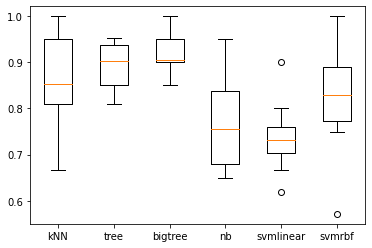

In [ ]:
import matplotlib.pyplot as plt

plt.boxplot([ scores for alg, scores in result.iteritems() ])
plt.xticks(1 + np.arange(result.shape[1]), result.columns)
plt.show()

## Comparar desempenho (validar hipótese)

In [ ]:
from scipy.stats import wilcoxon

In [ ]:
# Comparar dois algoritmos:
wilcoxon(result.kNN, result.tree)

/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:2879: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


WilcoxonResult(statistic=11.5, pvalue=0.6698153575994166)

In [ ]:
# Comparar todos contra todos: Friedman + Nemenyi (further reading), construir um diagrama de diferença crítica
# Orange3

## Melhor modelo (deploying)

In [ ]:
classifier = algorithms['bigtree']
classifier.fit(X, ycla) # Uso a base toda!
print(classifier.best_estimator_)

Pipeline(steps=[('imputer', SimpleImputer()),
                ('tree', DecisionTreeClassifier(random_state=17))])


In [ ]:
x = X.iloc[0:1, :]
print(x) # Faz de conta que é novo

   wheelbase  length  width  height  curbweight  enginesize  bore  stroke  \
0       88.6   168.8   64.1    48.8        2548         130  3.47    2.68   

   compressionratio  horsepower  peakrpm  citympg  highwaympg    price  
0               9.0       111.0   5000.0       21          27  13495.0  


In [ ]:
classifier.predict(x)

array([ True])

### Um outro modelo

In [ ]:
classifier = algorithms['svmrbf']
classifier.fit(X, ycla) # Uso a base toda
print(classifier.best_estimator_)

Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', StandardScaler()),
                ('pca', PCA(n_components=10, random_state=17)),
                ('svm', SVC(gamma=1.0, random_state=17))])


In [ ]:
print(x)
x.iloc[0, 13] = np.nan
print(x)
classifier.predict(x)

   wheelbase  length  width  height  curbweight  enginesize  bore  stroke  \
0       88.6   168.8   64.1    48.8        2548         130  3.47    2.68   

   compressionratio  horsepower  peakrpm  citympg  highwaympg    price  
0               9.0       111.0   5000.0       21          27  13495.0  
   wheelbase  length  width  height  curbweight  enginesize  bore  stroke  \
0       88.6   168.8   64.1    48.8        2548         130  3.47    2.68   

   compressionratio  horsepower  peakrpm  citympg  highwaympg  price  
0               9.0       111.0   5000.0       21          27    NaN  


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


array([ True])

## Regressão

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

from sklearn.pipeline import Pipeline

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.feature_selection import VarianceThreshold, SelectKBest
from sklearn.decomposition import PCA

from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import make_scorer

In [ ]:
scorer = make_scorer(mean_squared_error, greater_is_better=False)
algorithms = {}